# 0.01 — Data Exploration: Brickset LEGO Dataset 🧱

**Goal:**  
Understand the raw LEGO Brickset dataset and identify data quality issues that need to be addressed before modeling ROI.  

This notebook focuses on:
- Exploring the raw 
- Understanding column content and structure
- Identifying missing values and outliers
- Documenting insights to guide the cleaning pipeline


# 0. Setup & Imports

In [1]:
# Notebook setup
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import numpy as np

# Add project root to Python path
sys.path.append(str(Path.cwd().parent))

# Project imports
from src.process import load_sets, load_fx

sns.set_theme(style="whitegrid")

# 1. Load Data

We load:
- Raw Brickset LEGO dataset
- EUR/USD and EUR/GBP exchange rates

We **do not clean** the data yet — the purpose here is to understand the raw structure.


In [2]:
# Define paths
DATA_DIR = Path("../data/raw/brickset data")
USD_PATH = "../data/raw/exchange rate/eur_dolllar_rate.csv"
GBP_PATH = "../data/raw/exchange rate/eur_pound_rate.csv"

# Load data
df_raw = load_sets(DATA_DIR)
fx_usd, fx_gbp = load_fx(USD_PATH, GBP_PATH)

[process] Reading 25 file(s) from /Users/joscha/PythonProjects/lego-price-prediction/data/raw/brickset data


/Users/joscha/PythonProjects/lego-price-prediction/src/process.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


# 2. Initial Overview

We start by understanding:
- Shape of the dataset
- Column types
- Example rows

**Insight 1:** Several columns contain metadata (e.g., image links, EAN, UPC) that are not relevant for modeling and will likely be dropped during the cleaning phase to simplify the dataset.

**Insight 2:** A number of columns show high proportions of missing values, which will require a clear imputation or removal strategy in later steps.


In [3]:
# Shape of the dataset
print(f"Number of rows: {df_raw.shape[0]}")
print(f"Number of columns: {df_raw.shape[1]}")

Number of rows: 15833
Number of columns: 46


In [4]:
# Basic info
df_raw.info()
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15833 entries, 0 to 15832
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SetID                   15833 non-null  object 
 1   Number                  15833 non-null  object 
 2   Variant                 15833 non-null  object 
 3   YearFrom                15833 non-null  object 
 4   Category                15833 non-null  object 
 5   Theme                   15833 non-null  object 
 6   ThemeGroup              15832 non-null  object 
 7   Subtheme                14101 non-null  object 
 8   SetName                 15833 non-null  object 
 9   Image                   15351 non-null  object 
 10  ImageFilename           15351 non-null  object 
 11  USRetailPrice           10485 non-null  float64
 12  UKRetailPrice           9428 non-null   float64
 13  CARetailPrice           6618 non-null   float64
 14  DERetailPrice           5613 non-null 

,SetID,Number,Variant,YearFrom,Category,Theme,ThemeGroup,Subtheme,SetName,Image,...,WantCount,InstructionsCount,AdditionalImageCount,Released,Rating,BrickLinkSoldPriceNew,BrickLinkSoldPriceUsed,Designers,LaunchDate,ExitDate
0,133,1086,1,2000,Normal,Duplo,Pre-school,NaN,Bulk Bucket,X,...,28,0,0,X,0,NaN,NaN,NaN,09/10/2000 00:00:00,31/12/2001 00:00:00
1,174,1177,1,2000,Normal,Town,Modern day,Special,Santa's Truck,X,...,603,0,0,X,5,114.13,NaN,"Bjarke Lykke Madsen,",NaN,NaN
2,189,1196,1,2000,Normal,Town,Modern day,Telekom,Telekom Race Cyclist,X,...,555,0,0,X,11,20.00,12.77,"Bjarke Lykke Madsen,",NaN,NaN
3,190,1197,1,2000,Normal,Town,Modern day,Telekom,Telekom Race Cyclist and Television Motorbike,X,...,566,1,0,X,2,35.75,20.53,"Bjarke Lykke Madsen,",16/06/2000 00:00:00,31/12/2000 00:00:00
4,191,1198,1,2000,Normal,Town,Modern day,Telekom,Telekom Race Cyclists and Service Crew,X,...,557,1,0,X,8,47.39,40.00,"Bjarke Lykke Madsen,",16/06/2000 00:00:00,31/12/2000 00:00:00


In [5]:
# Null values per column
df_raw.isna().mean().sort_values(ascending=False).head(20)

ModelDimension3    0.878545
ModelDimension2    0.878545
ModelDimension1    0.878545
AgeMax             0.818733
Designers          0.770669
Weight             0.743763
DERetailPrice      0.645487
CARetailPrice      0.582012
Minifigs           0.551696
MinifigNumbers     0.549043
EAN                0.546454
UPC                0.536727
ExitDate           0.532243
LaunchDate         0.529969
USDateAdded        0.516642
USDateRemoved      0.516642
Depth              0.497695
Height             0.497316
Width              0.497253
AgeMin             0.490873
dtype: float64

# 3. Identify Irrelevant Columns

Columns such as `Image`, `ImageFilename`, `EAN`, `UPC`, and similar appear to be:
- Metadata for display (not predictive)
- Largely empty or constant
- Unrelated to price or ROI

They will be dropped during the cleaning phase to streamline the dataset and reduce noise.


In [6]:
irrelevant_cols = ["Image", "ImageFilename", "EAN", "USDateAdded", "USDateRemoved", "UPC", "Rating", "Released", "USItemNumber", "EUItemNumber", "AdditionalImageCount", "InstructionsCount"]
df_raw[irrelevant_cols].head()

,Image,ImageFilename,EAN,USDateAdded,USDateRemoved,UPC,Rating,Released,USItemNumber,EUItemNumber,AdditionalImageCount,InstructionsCount
0,X,1086-1,NaN,NaN,NaN,NaN,0,X,NaN,NaN,0,0
1,X,1177-1,NaN,NaN,NaN,NaN,5,X,NaN,NaN,0,0
2,X,1196-1,5.702012e+12,NaN,NaN,NaN,11,X,NaN,NaN,0,0
3,X,1197-1,5.702012e+12,NaN,NaN,NaN,2,X,NaN,NaN,0,1
4,X,1198-1,5.702012e+12,NaN,NaN,NaN,8,X,NaN,NaN,0,1


In [7]:
# Build a list of relevant columns
relevant_cols = [col for col in df_raw.columns if col not in irrelevant_cols]

# 4. Explore Missing Values

We now examine the missing data patterns across the relevant columns to assess data quality and identify potential issues that need to be addressed before modeling.


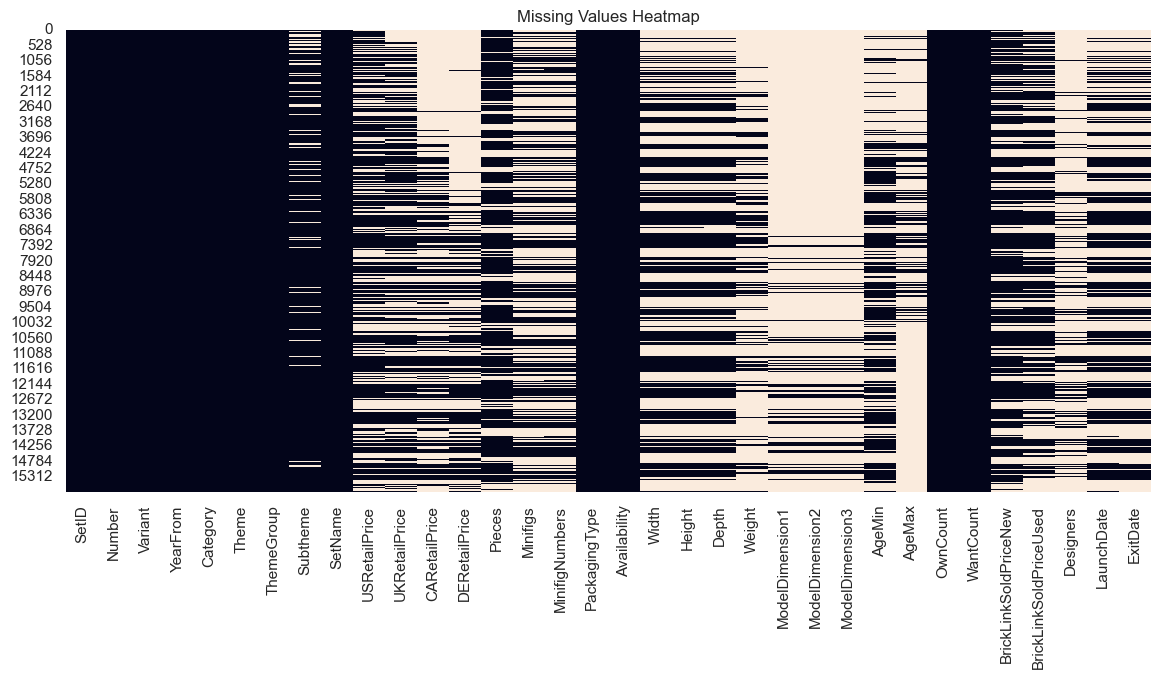

In [8]:
plt.figure(figsize=(14,6))
sns.heatmap(df_raw[relevant_cols].isna(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

### 4.1 Explore missing values in the price columns

**Insight 3:** Rows without any retail price data cannot be used for ROI modeling and will need to be removed during the cleaning phase.

In [9]:
price_cols = ["USRetailPrice", "UKRetailPrice", "CARetailPrice", "DERetailPrice"]

# Find rows where all price columns are NaN
missing_all_prices = df_raw[df_raw[price_cols].isna().all(axis=1)]

print(f"{missing_all_prices.shape[0]} of {df_raw.shape[0]} sets have no price information.")  # shows how many rows

4521 of 15833 sets have no price information.


# 5. Check for Data inconsistencies

**Insight 4:** There are nor invalid date ranges

### 5.1 Check for Launch Date > ExitDate

In [10]:
df_raw["LaunchDate"] = pd.to_datetime(df_raw["LaunchDate"], errors="coerce", dayfirst=True)
df_raw["ExitDate"] = pd.to_datetime(df_raw["ExitDate"], errors="coerce", dayfirst=True)

inconsistent_dates = (df_raw["LaunchDate"] > df_raw["ExitDate"]).sum()
print(f"Inconsistent dates: {inconsistent_dates}")


Inconsistent dates: 0


# 5. Price Exploration

In this step, we analyze the distribution of retail prices to understand price dynamics and identify potential modeling challenges such as skewness or outliers.

**Insight 5:** The price distribution is heavily right-skewed — most sets are priced below 100 €, while a small number of high-priced flagship sets drive the mean upward.
To address this imbalance, log transformation and/or outlier handling may be applied during the cleaning phase.

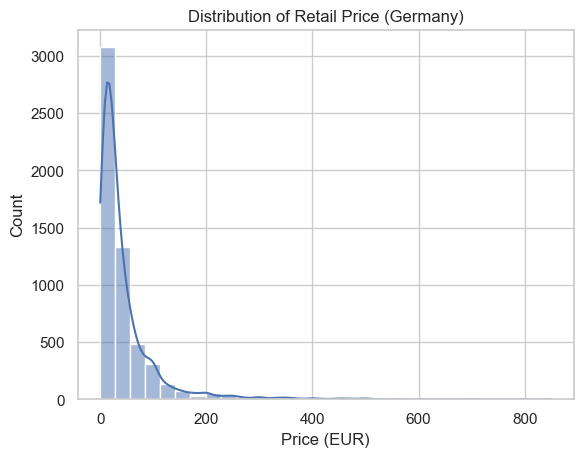

In [11]:
sns.histplot(data=df_raw, x="DERetailPrice", kde=True, bins=30)
plt.title("Distribution of Retail Price (Germany)")
plt.xlabel("Price (EUR)")
plt.show()

## 6. Most Common Themes

We also check the most frequent `Theme` values to understand the dataset composition.

**Insight 6:** A few popular themes dominate the dataset. Later, these may serve as categorical features.

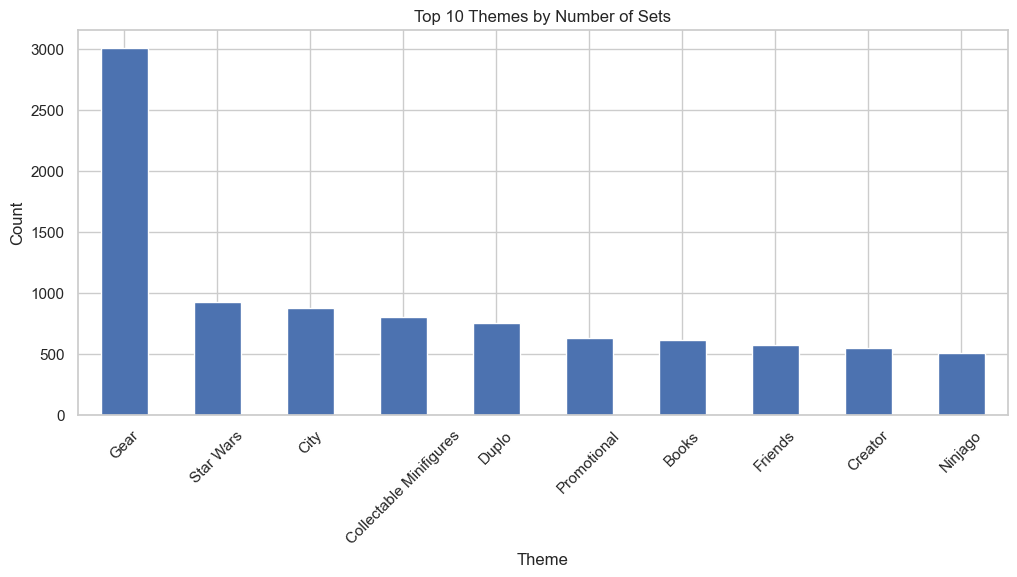

In [12]:
df_raw["Theme"].value_counts().head(10).plot(kind="bar", figsize=(12,5))
plt.title("Top 10 Themes by Number of Sets")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


## 7. Summary of Findings 🧭

| # | Insight | Action |
|---|---------|--------|
| 1 | Many metadata columns not useful for modeling | Drop in cleaning |
| 2 | Several columns have a high proportion of missing values | Drop or impute |
| 3 | Some rows have no retail price information | Remove these rows |
| 4 | No inconsistent date ranges (LaunchDate > ExitDate) | No action |
| 5 | Price distribution is heavily right-skewed | Apply log transformation or outlier handling |
| 6 | A few themes dominate the dataset | No action

Next step:  
We will implement these rules in `process.py` and apply the cleaning pipeline in the **next notebook** (Phase 1 — Cleaning & Feature Creation).
